# Глубинное обучение для текстовых данных, ФКН ВШЭ

## Домашнее задание 2: Рекуррентные нейронные сети

### Оценивание и штрафы

Максимально допустимая оценка за работу — __10 (+5) баллов__. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Весь код должен быть написан самостоятельно. Чужим кодом для пользоваться запрещается даже с указанием ссылки на источник. В разумных рамках, конечно. Взять пару очевидных строчек кода для реализации какого-то небольшого функционала можно.

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

__Мягкий дедлайн: 14.10.24 23:59__   
__Жесткий дедлайн: 17.10.24 23:59__

### О задании

В этом задании вам предстоит самостоятельно реализовать модель LSTM для решения задачи классификации с пересекающимися классами (multi-label classification). Это вид классификации, в которой каждый объект может относиться одновременно к нескольким классам. Такая задача часто возникает при классификации фильмов по жанрам, научных или новостных статей по темам, музыкальных композиций по инструментам и так далее.

В нашем случае мы будем работать с датасетом биотехнических новостей и классифицировать их по темам. Этот датасет уже предобработан: текст приведен к нижнему регистру, удалена пунктуация, все слова разделены проблелом.

In [1]:
#imports
import os
os.environ['http_proxy'] = "http://proxy-ws.cbank.kz:8080"
os.environ['https_proxy'] = "http://proxy-ws.cbank.kz:8080"

import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score

from collections import Counter

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import string

from tqdm import tqdm

from typing import List

import matplotlib.pyplot as plt

from transformers import AutoTokenizer

from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataset = pd.read_csv('data/biotech_news.tsv', sep='\t')
dataset.head()

,text,labels
0,drive your plow over the bones of the dead by ...,other
1,in the recently tabled national budget denel h...,other
2,shares take a break its good for you picture g...,other
3,reso is currently hiring for two positions pro...,other
4,charter buyer club what is the charter buyer c...,other


## Предобработка лейблов


__Задание 1 (1.5 балла)__. Как вы можете заметить, лейблы записаны в виде строк, разделенных запятыми. Для работы с ними нам нужно преобразовать их в числа. Так как каждый объект может принадлежать нескольким классам, закодируйте лейблы в виде векторов из 0 и 1, где 1 означает, что объект принадлежит соответствующему классу, а 0 – не принадлежит. Имея такую кодировку, мы сможем обучить модель, решая задачу бинарной классификации для каждого класса.

In [3]:
# your code here
dataset['labels'] = dataset['labels'].apply(lambda str: str.split(', '))

In [4]:
label_set = set()
for label_list in dataset['labels']:
    label_set.update(label_list)
label_set = sorted(label_set)

for index, label in enumerate(label_set):
    print(f"{index}) {label}")

0) alliance & partnership
1) article publication
2) clinical trial sponsorship
3) closing
4) company description
5) department establishment
6) event organization
7) executive appointment
8) executive statement
9) expanding geography
10) expanding industry
11) foundation
12) funding round
13) hiring
14) investment in public company
15) ipo exit
16) m&a
17) new initiatives & programs
18) new initiatives or programs
19) other
20) participation in an event
21) partnerships & alliances
22) patent publication
23) product launching & presentation
24) product updates
25) regulatory approval
26) service & product providing
27) subsidiary establishment
28) support & philanthropy


In [5]:
dataset['binary_mask'] = dataset['labels'].apply(lambda label_list: [1 if cur_label in label_list else 0 for cur_label in label_set]).tolist()

## Предобработка данных

В этом задании мы будем обучать рекуррентные нейронные сети. Как вы знаете, они работают лучше для коротких текстов, так как не очень хорошо улавливают далекие зависимости. Для уменьшение длин текстов их стоит почистить.

Сразу разделим выборку на обучающую и тестовую, чтобы считать все нужные статистики только по обучающей.

In [6]:
texts_train, texts_test, y_train, y_test = train_test_split(
    dataset['text'].tolist(),
    dataset['binary_mask'].tolist(),
    test_size=0.2,  # do not change this
    random_state=0  # do not change this
)

__Задание 2 (1.5 балла)__. Удалите из текстов стоп слова, слишком редкие и слишком частые слова. Гиперпараметры подберите самостоятельно (в идеале их стоит подбирать по качеству на тестовой выборке). Если вы считаете, что стоит добавить еще какую-то обработку, то сделайте это. Важно не удалить ничего, что может повлиять на предсказание класса.

In [7]:
english_stopwords = stopwords.words('english')

In [8]:
# your code here
def select_only_words(text):
    return [word for word in text.lower().split() if word.isalpha()]

In [9]:
def delete_words(
    words: List[List[str]],
    delete_word_set
):
    return [
        [word for word in word_list if word not in delete_word_set] 
            for word_list in words
    ]

In [10]:
# Оставим только буквенные
train_words = [select_only_words(sentence) for sentence in texts_train]
test_words = [select_only_words(sentence) for sentence in texts_test]

In [11]:
# Уберем стоп слова
train_words = delete_words(train_words, english_stopwords)
test_words = delete_words(test_words, english_stopwords)

In [12]:
lemmatizer = WordNetLemmatizer()

def lemmatize(words: List[List[str]]):
    return [
        [lemmatizer.lemmatize(word) for word in word_list] 
            for word_list in words
    ]

train_words = lemmatize(train_words)
test_words = lemmatize(test_words)

In [13]:
train_word_count = Counter()
for word_list in train_words:
    train_word_count.update(word_list)

print("Most common: ", train_word_count.most_common(5))
print("Moss rare: ", train_word_count.most_common()[:-10:-1])

# Решил что не буду удалять слишком частые слова
# только мб слишком редкие удалю
MIN_WORD_COUNT = 20
MAX_WORD_COUNT = 3700

freq_deleted_words = set()
for word_list in train_words:
    for word in word_list:
        if train_word_count[word] < MIN_WORD_COUNT or train_word_count[word] > MAX_WORD_COUNT:
            freq_deleted_words.add(word)

Most common:  [('company', 6218), ('said', 4992), ('health', 3637), ('year', 3574), ('care', 3339)]
Moss rare:  [('vandalism', 1), ('wheeled', 1), ('insuranceneighbor', 1), ('tsa', 1), ('noonday', 1), ('dfw', 1), ('hare', 1), ('beveridge', 1), ('lici', 1)]


In [14]:
train_words = delete_words(train_words, freq_deleted_words)
test_words = delete_words(test_words, freq_deleted_words)

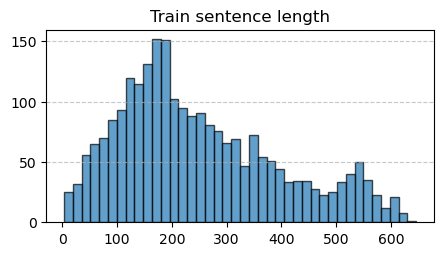

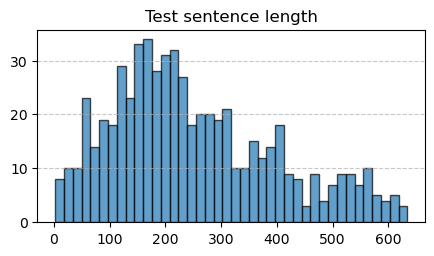

In [15]:
def plot_distr(nums: List[int], desc=''):
    plt.figure(figsize=(5, 2.5))
    plt.hist(nums, bins=40, edgecolor="black", alpha=0.7)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.title(desc)
    plt.show()

plot_distr(
    [len(sentence) for sentence in train_words],
    desc='Train sentence length'
)

plot_distr(
    [len(sentence) for sentence in test_words],
    desc='Test sentence length'
)

__Задание 3 (2 балла)__. Осталось перевести тексты в индексы токенов, чтобы их можно было подавать в модель. У вас есть две опции, как это сделать:
1. __(+0 баллов)__ Токенизировать тексты по словам.
2. __(до +5 баллов)__ Реализовать свою токенизацию BPE. Количество баллов будет варьироваться в зависимости от эффективности реализации. При реализации нельзя пользоваться специализированными библиотеками.

Токенизируйте тексты, переведите их в списки индексов и сложите вместе с лейблами в `DataLoader`. Не забудьте добавить в `DataLoader` `collate_fn`, которая будет дополнять все короткие тексты в батче паддингами. Для маппинга токенов в индексы вам может пригодиться `gensim.corpora.dictionary.Dictionary`.

In [16]:
# Я сейчас собираюсь схалтурить и использовать готовый токенизатор
# сейчас не хочу тратить время на реализацию токенизатора
# а так в приницпе написать BPE не сложно

# Ладно напишу тупо по словам токенизацию я заебался

class CustomTokenizer(TransformerMixin, BaseEstimator):
    def __init__(self):
        self.token_set = set()
        self.token_to_index = {}
        self.index_to_token = {}

        self.pad_token = '[PAD]'
        self.pad_token_id = None
        self.unk_token = '[UNK]'
        self.unk_token_id = None

        self.token_set.add(self.pad_token)
        self.token_set.add(self.unk_token)

        self.vocab_size = None

    def fit(self, documents: List[List[str]]):
        for sentence in documents:
            for word in sentence:
                self.token_set.add(word)
        self.token_to_index = {token : index for index, token in enumerate(self.token_set)}
        self.index_to_token = {index : token for index, token in enumerate(self.token_set)}

        self.pad_token_id = self.token_to_index[self.pad_token]
        self.unk_token_id = self.token_to_index[self.unk_token]

        self.vocab_size = len(self.token_set)
        
    def transform(self, token_list: List[str]):
        token_indices = []
        for token in token_list:
            if token not in self.token_to_index:
                token_indices.append(self.unk_token_id)
            else:
                token_indices.append(self.token_to_index[token])
        return token_indices

    def reverse_transform(self, index_list: List[int]):
        token_list = [self.index_to_token[index] for index in index_list]
        return token_list


In [17]:
tokenizer = CustomTokenizer()
tokenizer.fit(train_words)

print(tokenizer.vocab_size)

4935


In [18]:
train_indices = [torch.LongTensor(tokenizer.transform(word_list)) for word_list in train_words]
test_indices = [torch.LongTensor(tokenizer.transform(word_list)) for word_list in test_words]

In [19]:
class CustomDataset(Dataset):
    def __init__(self, encoded_indices, label_masks):
        self.encoded_indices = encoded_indices
        self.label_masks = label_masks
        
    def __len__(self):
        return len(self.encoded_indices)
        
    def __getitem__(self, index):
        return self.encoded_indices[index], self.label_masks[index]

In [20]:
def collate_fn(batch_and_label):
    batch, labels = [], []
    for pair in batch_and_label:
        batch.append(pair[0])
        labels.append(pair[1])
    padded_batch = pad_sequence(batch, batch_first=True, padding_value=tokenizer.pad_token_id)
    return padded_batch, label

In [21]:
train_dataset = CustomDataset(train_indices, y_train)
test_dataset = CustomDataset(test_indices, y_test)

In [22]:
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False
)

In [23]:
next(iter(train_loader))

(tensor([[ 327,  328, 2810,  ..., 3287, 3287, 3287],
         [2750, 3710, 2559,  ..., 3287, 3287, 3287],
         [4486, 4018, 4668,  ..., 1045, 2943, 1077],
         ...,
         [3504,  980, 4214,  ..., 3287, 3287, 3287],
         [3803,  614, 4821,  ..., 3287, 3287, 3287],
         [1133, 1817,   50,  ..., 3287, 3287, 3287]]),
 'support & philanthropy')

## Метрика качества

Перед тем, как приступить к обучению, нам нужно выбрать метрику оценки качества. Так как в задаче классификации с пересекающимися классами классы часто несбалансированы, чаще всего в качестве метрики берется [F1 score](https://en.wikipedia.org/wiki/F-score).

Функция `compute_f1` принимает истинные метки и предсказанные и считает среднее значение F1 по всем классам. Используйте ее для оценки качества моделей.

$$
F1_{total} = \frac{1}{K} \sum_{k=1}^K F1(Y_k, \hat{Y}_k),
$$
где $Y_k$ – истинные значения для класса k, а $\hat{Y}_k$ – предсказания.

In [24]:
def compute_f1(y_true, y_pred):
    assert y_true.ndim == 2
    assert y_true.shape == y_pred.shape

    return f1_score(y_true, y_pred, average='macro')

## Обучение моделей

### RNN

В качестве бейзлайна обучим самую простую рекуррентную нейронную сеть. Напомним, что блок RNN выглядит таким образом.

<img src="https://i.postimg.cc/yYbNBm6G/tg-image-1635618906.png" alt="drawing" width="400"/>

Его скрытое состояние обновляется по формуле
$h_t = \sigma(W x_{t} + U h_{t-1} + b_h)$. А предсказание считается с помощью применения линейного слоя к последнему токену
$o_T = V h_T + b_o$. В качестве функции активации выберите гиперболический тангенс. 

__Задание 4 (2 балла)__. Реализуйте RNN в соответствии с формулой выше и обучите ее на нашу задачу. Нулевой скрытый вектор инициализируйте нулями, так модель будет обучаться стабильнее, чем при случайной инициализации. После этого замеряйте качество на тестовой выборке. У вас должно получиться значение F1 не меньше 0.33, а само обучение не должно занимать много времени.

In [25]:
# your code here
class RNNCell(nn.Module):
    def __init__(self, num_tokens, embedding_size, hidden_embedding_size, output_size):
        super(self.__class__, self).__init__()
        self.num_tokens = num_tokens
        self.embedding_size = embedding_size
        self.hidden_embedding_size = hidden_embedding_size

        self.activation = nn.Tanh()
        self.embed_layer = nn.Embedding(num_tokens, embedding_size)

        self.concat_to_hidden = nn.Linear(embedding_size + hidden_embedding_size, hidden_embedding_size)
        self.classifier_to_raw_logits = nn.Linear(hidden_embedding_size, output_size)

    def forward(self, batch_indices, last_hidden_state):
        batch_size = batch_indices.shape[0]
        # (batch_size, embedding_size)
        batch_embeds = self.embed_layer(batch_indices)
        # (batch_size, embedding_size + hidden_embedding_size)
        concat_state = torch.cat([batch_embeds, last_hidden_state], dim=-1)
        # (batch_size, hidden_embedding_size)
        new_hidden_state = self.activation(self.concat_to_hidden(concat_state))
        # (batch_size, output_size)
        raw_logits = self.classifier_to_raw_logits(new_hidden_state)

        return {
            'hidden_state' : new_hidden_state,
            'raw_logits' : raw_logits
        }

    def get_zero_state(self, batch_size):
        return torch.zeros(batch_size, self.hidden_embedding_size, requires_grad=True)

In [26]:
def rnn_loop(rnn_cell: RNNCell, batch_indices):
    batch_size = batch_indices.shape[0]
    zero_state = rnn_cell.get_zero_state(batch_size)
    batch_slices = torch.transpose(batch_indices, 1, 0)
    for batch_slice in batch_slices:
        print("batch slice shape: ", batch_slice.shape)

In [27]:
rnn_config = {
    'batch_size' : 8,
    'num_tokens' : tokenizer.vocab_size,
    'embedding_size' : 32,
    'hidden_embedding_size' : 64,
    'output_size' : 50
}

In [28]:
rnn_cell = RNNCell(
    num_tokens=rnn_config['num_tokens'],
    embedding_size=rnn_config['embedding_size'],
    hidden_embedding_size=rnn_config['hidden_embedding_size'],
    output_size=rnn_config['output_size']
)

In [29]:
batch = next(iter(train_loader))

In [30]:
output = rnn_loop(rnn_cell, batch)

AttributeError: 'tuple' object has no attribute 'shape'

### LSTM

<img src="https://i.postimg.cc/pL5LdmpL/tg-image-2290675322.png" alt="drawing" width="400"/>

Теперь перейдем к более продвинутым рекурренным моделям, а именно LSTM. Из-за дополнительного вектора памяти эта модель должна гораздо лучше улавливать далекие зависимости, что должно напрямую отражаться на качестве.

Параметры блока LSTM обновляются вот так ($\sigma$ означает сигмоиду):
\begin{align}
f_{t} &= \sigma(W_f x_{t} + U_f h_{t-1} + b_f) \\ 
i_{t} &= \sigma(W_i x_{t} + U_i h_{t-1} + b_i) \\
\tilde{c}_{t} &= \tanh(W_c x_{t} + U_c h_{t-1} + b_i) \\
c_{t} &= f_t \odot c_{t-1} + i_t \odot \tilde{c}_t \\
o_{t} &= \sigma(W_t x_{t} + U_t h_{t-1} + b_t) \\
h_t &= o_t \odot \tanh(c_t)
\end{align}

__Задание 5 (2 балла).__ Реализуйте LSTM по описанной схеме. Выберите гиперпараметры LSTM так, чтобы их общее число (без учета слоя эмбеддингов) примерно совпадало с числом параметров обычной RNN, но размерность скрытого слоя была не меньше 64. Так мы будем сравнивать архитектуры максимально независимо. Обучите LSTM до сходимости и сравните качество с RNN на тестовой выборке. Удалось ли получить лучший результат? Как вы можете это объяснить?

In [ ]:
# your code here

__Задание 6 (1 балл).__ В этом задании у вас есть две опции на выбор: добавить __двунаправленность__ для LSTM _или_ добавить __многослойность__. Можно сделать и то, и другое, но дополнительных баллов за это мы не дадим, только бесконечный респект. Обе модификации реализуются довольно просто (буквально 4 строчки кода, если вы аккуратно реализовали модель) и дают примерно одинаковый прирост в качестве. Сделайте выводы: стоит ли увеличивать размер модели в несколько раз?

In [ ]:
# your code here